In [32]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [33]:
root_path = 'gdrive/My Drive/Colab Notebooks/ML/Task 1/'
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
import os
import torch
import time
import torch.nn as nn
import torch.nn.utils.prune as prune
from torchvision.transforms import transforms
from torch.optim import lr_scheduler
from torchvision import datasets
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
import copy
from torch.utils.tensorboard import SummaryWriter

# Create writer for tensorboard
writer = SummaryWriter('runs/Scratch-CNN')


In [35]:
# Slight data augmentation and normalization for training
# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

#Create datasets in dictionary with for loop passing in dir names and adding transform to tensor and normalize
image_datasets = {x: datasets.ImageFolder(os.path.join(root_path, x),data_transforms[x])
                  for x in ['train', 'val', 'test']}
#Load datasets in same way shuffle and make batch size 4 this can be tuned, workers at 2 for colab
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
#Similar process read in dataset sizes for accuracy later on
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#Read in classes from train, could be any as long as all directories have all classes
class_names = image_datasets['train'].classes

#Change to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Check what device is being used as well as dataset sizes
print(device)
print(dataset_sizes)

cuda:0
{'train': 1287, 'val': 389, 'test': 412}


In [36]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        #Conv2d extract features
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #BN1 change to out_chanels
        self.bn1=nn.BatchNorm2d(num_features=12)
        #RELU linear activation function
        self.relu1=nn.ReLU()
        #Maxpool2d extract features
        self.pool=nn.MaxPool2d(kernel_size=2)

        #2nd Conv2d extract features
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #2nd relu linear activation function
        self.relu2=nn.ReLU()
        
        
        #3rd conv2d extract features
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #3rd bn change to out_chanels
        self.bn3=nn.BatchNorm2d(num_features=32)
        #3rd relu linear activation function
        self.relu3=nn.ReLU()
        
        #linear layer for output for classification
        self.fc=nn.Linear(in_features=128 * 128 * 32,out_features=num_classes)
      
    #Feed forward function
    def forward(self,input):
      #input for conv is output of next and so on
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        #Output same as in features
        output=output.view(-1,32*128*128)
        #Final Out for classification
        output=self.fc(output)
        return output

In [37]:
#Train model function again more comments
def train_model(model, criterion, optimizer, scheduler, num_epochs, device):
  """
  Function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion loss function
    optimizer: Optimizer to use for training
    scheduler: Instance of torch.optim.lr_scheduler
    num_epochs: Number of epochs
    device: Device to run the training on, CUDA or CPU on colab.
  """
  #Time taken to train start
  since = time.time()

  #Copy current weights 
  best_model_wts = copy.deepcopy(model.state_dict())
  #Set accuracy
  best_acc = 0.0
  
  #For loop for training
  for epoch in range(num_epochs):
    #Printing epochs
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode
      #Set running loss and correct count
      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        #Send to device for training
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      #Step each train
      if phase == 'train':
        scheduler.step()
      #Calculate loss and accuracy
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      #Print loss accuracy and phase
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      #Send to tensorboard to be plotted
      if phase == 'train':
          writer.add_scalar('Training Loss', epoch_loss/1000, epoch * len(dataloaders['train']))
          writer.add_scalar('Training Accuracy', epoch_acc, epoch)
      else:
        writer.add_scalar('Validaiton Loss', epoch_loss/1000, epoch * len(dataloaders['val']))
        writer.add_scalar('Validation Accuracy', epoch_acc, epoch)

      # deep copy the model when decent score
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  #When complete calc time taken
  time_elapsed = time.time() - since
  #Print time taken and validation accuracy 
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights and send back trained model
  model.load_state_dict(best_model_wts)
  return model


In [38]:
#Call model to device and class number
model_conv=ConvNet(num_classes=6).to(device)
#Set number of features to the num of features model will look for
num_ftrs = model_conv.fc.in_features
#Set feautres value and send num of classes
model_conv.fc = nn.Linear(num_ftrs, 6)
#Set to device
model_conv = model_conv.to(device)
#Create loss function 
criterion = nn.CrossEntropyLoss()

#Create optimiser for model
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

#Set schedular, decay learning rate by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.3)

Epoch 0/0
----------
train Loss: 96.9366 Acc: 0.4141
val Loss: 78.8922 Acc: 0.5990

Training complete in 0m 20s
Best val Acc: 0.598972
Testing model
tensor([[15., 28.,  0., 10.,  1.,  6.],
        [ 0., 89.,  0.,  0.,  1.,  0.],
        [ 3., 51., 11.,  0.,  0.,  3.],
        [ 6., 53.,  1., 28.,  2., 10.],
        [ 0., 24.,  0.,  2., 20.,  0.],
        [ 6., 13.,  3.,  5.,  0., 21.]])
tensor([0.2500, 0.9889, 0.1618, 0.2800, 0.4348, 0.4375])


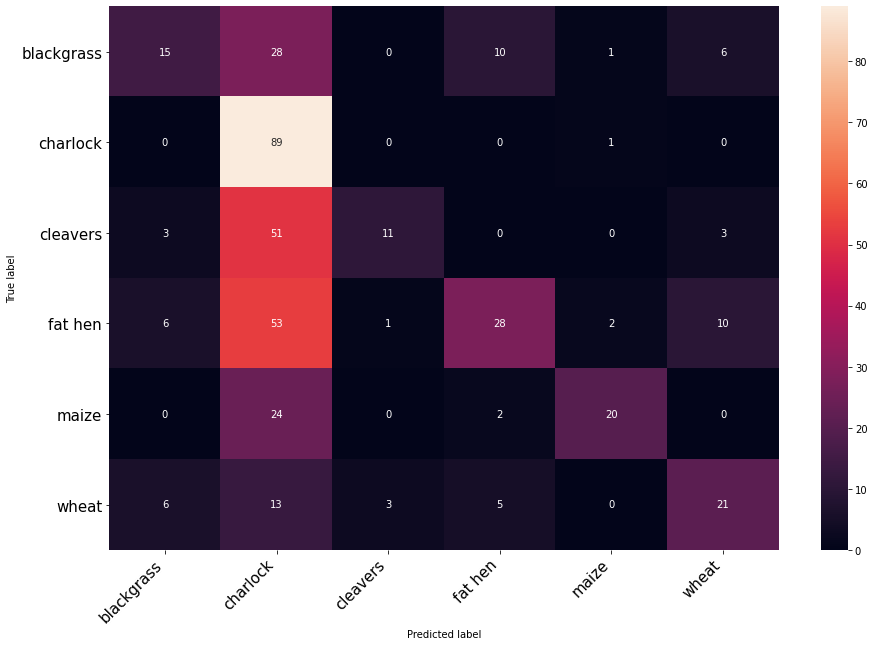

In [39]:
#Train model
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                             num_epochs=1, device=device)
#Prune model to make lighter for actual deployment
for name, module in model_conv.named_modules():
    # prune 20% of connections in all 2D-conv layers 
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
        prune.remove(module, 'weight')
    # prune 40% of connections in all linear layers 
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)
        prune.remove(module, 'weight')

#Call test data
images, labels = next(iter(dataloaders['test']))
#Send images to device to test and send to tensorboard same as model
images = images.to(device)
#Send to tensorboard
writer.add_graph(model_conv, images)
#Time to test model
print("Testing model")
#Set confusion matric up as 6x6 (num of classes)
confusion_matrix = torch.zeros(6, 6)
#For loop for test and assigning to confusion matrix for multi class
with torch.no_grad():
    for i, (images, labels) in enumerate(dataloaders['test']):
        #Set images and labels to same device as model
        images = images.to(device)
        labels = labels.to(device)
        #Pass model image
        outputs = model_conv(images)
        #Compare model prediction with actual
        _, pred = torch.max(outputs, 1)
        #For loop to add to confusion matrix
        for t, p in zip(labels.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] +=1
#Print matrix created
print(confusion_matrix)
#Find each class accuracy
accuracy_individ = confusion_matrix.diag()/confusion_matrix.sum(1)
#Print each class accuracy
print(accuracy_individ)

#Plot figure for easier understanding of model
plt.figure(figsize=(15,10))
#Set to dataframe for seaborn heatmap
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
#Call heatmap with dataframe
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
#Set colours and labels for display
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
#Save for later use
conf = root_path + "Conf_matrix_Scratch-CNN.png"
plt.savefig(conf)



In [40]:
#convert accuracies to numpy
accuracy_indi = accuracy_individ.numpy()
#Convert matrix to numpy
matrix = confusion_matrix.numpy()
#Total up each class verical from matrix
totals = np.sum(matrix, axis = 1)
#Total up each class horizontal from matrix
fp_total = np.sum(matrix, axis = 0)


overall_total = sum(totals + fp_total)
#Evaluation metrics for loop
for i in range(6):
  total = totals[i]
  TP = total * accuracy_indi[i]
  FN = total - TP
  FP = fp_total[i] - TP
  TN = overall_total -(total + fp_total[i])
  Accuracy = (TP + TN)/ (TP + FP + TN + FN)
  Precision = TP / (TP + FP)
  Recall = TP / (TP + FN)
  Specificity = TN / (TN + FP)
  F1 = (2*TP) / (2*TP + FP + FN)
  MCC = ((TP * TN) - (FP *FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) )
  Error_rate = (FP + FN)/ (TP + FP + TN + FN) 
  Sensitivity = TP / (TP +FN)
  print(class_names[i].capitalize())
  print("True Positive value = " + str(TP))
  print("False Negative value = " + str(FN))
  print("False Positive value = " + str(FP))
  print("True Negative value = " + str(TN))
  print("Accuracy = " + str(Accuracy))
  print("Precision = " + str(Precision))
  print("Recall = " + str(Recall))
  print("Specificity = " + str(Specificity))
  print("F1 Score = " + str(F1))
  print("MCC = " + str(MCC))
  print("Error Rate = " + str(Error_rate))
  print("Sensitivity = " + str(Sensitivity))
  print()

#Save the model for later use to be deployed using torchserve
s = torch.jit.script(model_conv)
torch.jit.save(s, root_path + 'Scratch-CNN.pt')

Blackgrass
True Positive value = 15.0
False Negative value = 45.0
False Positive value = 15.0
True Negative value = 734.0
Accuracy = 0.9258343634116193
Precision = 0.5
Recall = 0.25
Specificity = 0.9799732977303071
F1 Score = 0.3333333333333333
MCC = 0.3189073955189441
Error Rate = 0.07416563658838071
Sensitivity = 0.25

Charlock
True Positive value = 89.0
False Negative value = 1.0
False Positive value = 169.0
True Negative value = 476.0
Accuracy = 0.7687074829931972
Precision = 0.34496123
Recall = 0.98888886
Specificity = 0.737984496124031
F1 Score = 0.5114942528735632
MCC = 0.4992186904233362
Error Rate = 0.23129251700680273
Sensitivity = 0.98888886

Cleavers
True Positive value = 11.0
False Negative value = 57.0
False Positive value = 4.0
True Negative value = 741.0
Accuracy = 0.9249692496924969
Precision = 0.73333335
Recall = 0.16176471
Specificity = 0.9946308724832215
F1 Score = 0.26506024096385544
MCC = 0.3217436527128749
Error Rate = 0.07503075030750307
Sensitivity = 0.16176471

In [41]:
!tensorboard dev upload \
  --logdir  runs/Scratch-CNN\
  --name "Scratch CNN Model" \
  --description "Relevant information on model found here" \
  --one_shot

2021-04-19 20:30:30.688797: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

runs/Scratch-CNN

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 75, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.config